In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('ggplot')
np.random.seed(1232)
np.set_printoptions(formatter={'all':lambda x: '%.3f' % x})

In [2]:
from scipy.optimize import minimize
from scipy.stats import bernoulli, binom,uniform
from scipy.special import comb
from scipy.stats import binom, bernoulli

In [3]:
from keras.datasets import mnist
from sklearn.utils import shuffle


In [4]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
# train_X = np.where(train_X>0.5,1,0)
train_X = (train_X/128).astype('int')

In [10]:
p_1 =  np.prod(thetas[0,:] ** x * (1-thetas[0,:])**(1-x), axis=1) * phi[0]


In [17]:
p_1.shape

(1800,)

In [5]:
n = 600
m = n *3
sz = 28

tol = 1e-15
max_iter = 100

initWts = np.random.uniform(.25,.75,3)
tot = np.sum(initWts)
initWts = initWts/tot
phi = initWts

elbo_old = -1000000

x = np.array([train_X[np.where(train_y==2)[0][0:n],:,:],
                train_X[np.where(train_y==9)[0][0:n],:,:],
                train_X[np.where(train_y==3)[0][0:n],:,:]])
x = x.reshape(m,sz*sz,order='C')
x = shuffle(x)

# uni_model = uniform(loc=0.25,scale=0.5)
# thetas = np.array([uni_model.rvs(size=sz*sz),
#                    uni_model.rvs(size=sz*sz),
#                    uni_model.rvs(size=sz*sz)])
# dummy = np.sum(thetas,axis=1)
# thetas = thetas/dummy[:,np.newaxis]

initMeans = np.full((3, sz*sz), 1.0/3)
thetas = initMeans


In [6]:
# for i in range(3):  
#     ax = plt.subplot(1,3,i+1)
#     ax.imshow(x[i,i], cmap=plt.get_cmap('gray'))
# plt.show()
# dummy = x.reshape(m,sz,sz,order='C')
# print(dummy.shape)
# plt.imshow(dummy[60,:],cmap=plt.get_cmap('gray'))

In [7]:
for i in range(max_iter):

    p_1 =  np.prod(thetas[0,:] ** x * (1-thetas[0,:])**(1-x), axis=1) * phi[0]
    p_2 =  np.prod(thetas[1,:] ** x * (1-thetas[1,:])**(1-x), axis=1) * phi[1]
    p_3 =  np.prod(thetas[2,:] ** x * (1-thetas[2,:])**(1-x), axis=1) * phi[2]

    p_1 = p_1.clip(min=1e-50)
    p_2 = p_2.clip(min=1e-50)
    p_3 = p_3.clip(min=1e-50)
    # p_1 = np.sum(p_1,axis=1)
    # p_2 = np.sum(p_2,axis=1)
    # p_3 = np.sum(p_3,axis=1)


    # p_1[np.isnan(p_1)]=-100
    # p_2[np.isnan(p_2)]=-100
    # p_3[np.isnan(p_3)]=-100

    # denom = np.exp(p_1) + np.exp(p_2) + np.exp(p_3)

    # w_1 = 1/(1+ np.exp(p_2-p_1) + np.exp(p_3-p_1))
    # w_2 = 1/(1+ np.exp(p_1-p_2) + np.exp(p_3-p_2))
    # w_3 = 1/(1+ np.exp(p_2-p_3) + np.exp(p_1-p_3))
    # w_1 = np.exp(p_1)/denom
    # w_2 = np.exp(p_2)/denom
    # w_3 = np.exp(p_3)/denom

    w_1 = p_1/(p_1+p_2+p_3)
    w_2 = p_2/(p_1+p_2+p_3)
    w_3 = p_3/(p_1+p_2+p_3)


    # elbo = np.sum(w_1 * p_1 + w_2 * p_2 + w_3 * p_3)

    elbo = np.sum(w_1 * np.log(p_1/w_1) + w_2 * np.log(p_2/w_2) + w_3 * np.log(p_3/w_3))


    # thetas[0,:] = np.sum(w_1[:,np.newaxis] * x,axis=0)/np.sum(w_1 ,axis=0) + 0.0001
    # thetas[1,:] = np.sum(w_2[:,np.newaxis] * x,axis=0)/np.sum(w_2 ,axis=0) + 0.0001
    # thetas[2,:] = np.sum(w_3[:,np.newaxis] * x,axis=0)/np.sum(w_3,axis=0) + 0.0001

    thetas[0,:] = np.sum(w_1[:,np.newaxis]*x,axis=0) / np.sum(w_1)
    thetas[1,:] = np.sum(w_2[:,np.newaxis]*x,axis=0) / np.sum(w_2)
    thetas[2,:] = np.sum(w_3[:,np.newaxis]*x,axis=0) / np.sum(w_3)

    phi[0] = np.sum(w_1)/m
    phi[1] = np.sum(w_2)/m
    phi[2] = np.sum(w_3)/m

    print(f"Iteration: {i}")
    print(f"ELBO is: {elbo}")
    if np.abs(elbo-elbo_old) < tol:
        break
    elbo_old = elbo

Iteration: 0
ELBO is: -205255.1562498615
Iteration: 1
ELBO is: -205255.1562498615


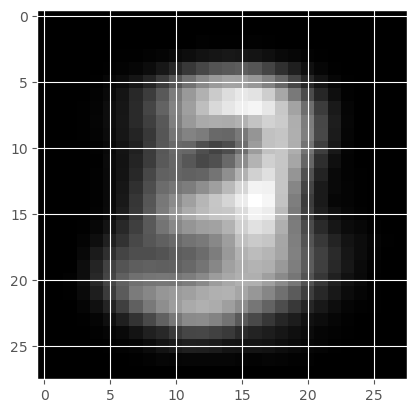

In [8]:
test = thetas.reshape(3,28,28)
plt.imshow(test[2,:],cmap=plt.get_cmap('gray'))

In [9]:
phi

array([0.333, 0.333, 0.333])